![Logo TUBAF](https://tu-freiberg.de/sites/default/files/media/freiberger-alumni-netzwerk-6127/wbm_orig_rgb_0.jpg)

Exercise material of the MSc-level course **Soil Dynamics**.
Held at Technische Universität Bergakademie Freiberg.

Comments to:

*Prof. Dr. Thomas Nagel  
Chair of Soil Mechanics and Foundation Engineering  
Geotechnical Institute  
Technische Universität Bergakademie Freiberg.*

https://tu-freiberg.de/en/fakultaet3/gt/soilmechanics


# Einmassenschwinger, Frequenzanalyse

![oscillator1dof.png](https://github.com/nagelt/soil_dynamics/raw/master/Images/oscillator1dof.png)

## Hilfsfunktionen

Module laden

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal.windows import hann   

Eingeschwungenen Zustand (partikuläre Lösung) berechnen, inklusive Vergrößerungsfunktion und Phasendifferenz

In [2]:
def steady_state_solution(omega, omega_0, zeta, a_c, a_s):
    eta = omega/omega_0
    if eta==1 and zeta==0:   # TODO implement solutions up1(t) and up2(t) for this case as done for uh(t)
        print("Warning: no steady-state solution for resonant excitation of undamped oscillator!")
        V = 0 
        psi = 0
        u_c = 0
        u_s = 0
    else:        
        V2 = 1.0/( (1-eta**2)**2 + (2*eta*zeta)**2 )
        V = np.sqrt(V2)
        psi = np.arctan2(2*zeta*eta, 1-eta**2)
        u_c = V2*( (1-eta**2)*a_c - 2*zeta*eta*a_s )
        u_s = V2*( (1-eta**2)*a_s + 2*zeta*eta*a_c )
    return [u_c, u_s, V, psi]

Anpassen der Gesamtlösung an die Anfangsbedingungen

In [3]:
def transient_solution(t_0, u_0, v_0):
    uh_c1 = uh_1(t_0)
    uh_c2 = uh_2(t_0)
    vh_c1 = vh_1(t_0)
    vh_c2 = vh_2(t_0)
    up_0 = up(t_0)
    vp_0 = vp(t_0)
    # LGS Ax=b
    A = np.array([[uh_c1, uh_c2], [vh_c1, vh_c2]])
    b = np.array([u_0-up_0, v_0-vp_0])
    x = np.linalg.solve(A, b)
    C_1 = x[0]
    C_2 = x[1]
    return [C_1, C_2]

## Simulation 

Parameterdefinition

In [4]:
m = 3.0   # kg
k = 10.0   # N/m
c = 1.0   # Ns/m   critical damping for c=2*sqrt(k*m)=10.95445115...
t_0 = 0.0   # s
u_0 = 0.0   # m
v_0 = 0.0   # m/s
#excitation (discrete spectrum)
T_a =  9.0  # s
A_0 =  0.0  # m
A_1 =  0.0  # m
B_1 =  1.0  # m
A_2 =  0.2  # m
B_2 =  0.0  # m
A_3 = -0.2  # m
B_3 =  0.4  # m

omega=2*np.pi/T_a
omega_0 = np.sqrt(k/m)
zeta = c/(2*np.sqrt(k*m))

Eingangspektrum

In [5]:
a0 = lambda t: A_0
a1 = lambda t: A_1*np.cos(1*omega*t) + B_1*np.sin(1*omega*t)
a2 = lambda t: A_2*np.cos(2*omega*t) + B_2*np.sin(2*omega*t)
a3 = lambda t: A_3*np.cos(3*omega*t) + B_3*np.sin(3*omega*t)
# superposition of excitation
a  = lambda t: a0(t) + a1(t) + a2(t) + a3(t) 

Partikulärlösung

In [6]:
# DC component u=a, v=0
up0 = lambda t: A_0
vp0 = lambda t: A_0

[u_c1, u_s1, V, psi] = steady_state_solution(1*omega, omega_0, zeta, A_1, B_1)
up1 = lambda t: u_c1*np.cos(1*omega*t) + u_s1*np.sin(1*omega*t)
vp1 = lambda t: (-u_c1*np.sin(1*omega*t) + u_s1*np.cos(1*omega*t)) * 1*omega

[u_c2, u_s2, V, psi] = steady_state_solution(2*omega, omega_0, zeta, A_2, B_2)
up2 = lambda t: u_c2*np.cos(2*omega*t) + u_s2*np.sin(2*omega*t)
vp2 = lambda t: (-u_c2*np.sin(2*omega*t) + u_s2*np.cos(2*omega*t)) * 2*omega

[u_c3, u_s3, V, psi] = steady_state_solution(3*omega, omega_0, zeta, A_3, B_3)
up3 = lambda t: u_c3*np.cos(3*omega*t) + u_s3*np.sin(3*omega*t)
vp3 = lambda t: (-u_c3*np.sin(3*omega*t) + u_s3*np.cos(3*omega*t)) * 3*omega

# superposition of particular solutions
up = lambda t: up0(t) + up1(t) + up2(t) + up3(t)
vp = lambda t: vp0(t) + vp1(t) + vp2(t) + vp3(t)

Lösung der homogenen Gleichung

In [7]:
if zeta < 1:
    omega_1 = omega_0*np.sqrt(1-zeta**2)
    delta = omega_0*zeta
    print("omega_1={:.3f} rad/s".format(omega_1), "   delta={:.3f} 1/s".format(delta))
    uh_1 = lambda t: np.exp(-delta*t)*np.cos(omega_1*t)
    uh_2 = lambda t: np.exp(-delta*t)*np.sin(omega_1*t)
    vh_1 = lambda t: np.exp(-delta*t)*( -delta*np.cos(omega_1*t) - omega_1*np.sin(omega_1*t) )
    vh_2 = lambda t: np.exp(-delta*t)*( -delta*np.sin(omega_1*t) + omega_1*np.cos(omega_1*t) )
elif zeta > 1:
    delta_1 = omega_0*(zeta - np.sqrt(zeta**2 - 1))
    delta_2 = omega_0*(zeta + np.sqrt(zeta**2 - 1))
    print("delta_1={:.3f} 1/s".format(delta_1), "   delta_2={:.3f} 1/s".format(delta_2) )
    uh_1 = lambda t: np.exp(-delta_1*t)
    uh_2 = lambda t: np.exp(-delta_2*t)
    vh_1 = lambda t: np.exp(-delta_1*t)*(-delta_1)
    vh_2 = lambda t: np.exp(-delta_2*t)*(-delta_2)
else:
    delta = omega_0*zeta
    print("delta={:.3f} 1/s".format(delta), "   (critical damping)")
    uh_1 = lambda t: np.exp(-delta*t)
    uh_2 = lambda t: t*np.exp(-delta*t)
    vh_1 = lambda t:-np.exp(-delta*t)*delta
    vh_2 = lambda t: np.exp(-delta*t) - t*np.exp(-delta*t)*delta

omega_1=1.818 rad/s    delta=0.167 1/s


Gesamtlösung für das erste Intervall (*Erdbeben*)

In [8]:
[C_1, C_2] = transient_solution(t_0, u_0, v_0)

uh = lambda t: C_1*uh_1(t) + C_2*uh_2(t) 
u = lambda t:  uh(t) + up(t) 
vh = lambda t: C_1*vh_1(t) + C_2*vh_2(t) 
v = lambda t:  vh(t) + vp(t) 

t_T = t_0 + T_a
u_T = u(t_T) 
v_T = v(t_T)
t_sample_T = np.linspace(t_0, t_T , 250)   # discretization with 250 points in time
a_sample_T  =  a(t_sample_T)
uh_sample_T = uh(t_sample_T)
up_sample_T = up(t_sample_T)
u_sample_T  =  u(t_sample_T)


Gesamtlösung für das zweite Intervall (*Nachwirkung*)

In [9]:
a  = lambda t: 0*t
up = lambda t: 0*t
vp = lambda t: 0*t

[C_1, C_2] = transient_solution(t_T, u_T, v_T)   # end of first intervall is begin of second
uh = lambda t: C_1*uh_1(t) + C_2*uh_2(t) 
u = lambda t:  uh(t) + up(t) 
vh = lambda t: C_1*vh_1(t) + C_2*vh_2(t) 
v = lambda t:  vh(t) + vp(t) 

t_2T = t_T + T_a
t_sample_2T = np.linspace(t_T, t_2T , 250)   # discretization with 250 points in time
a_sample_2T = a(t_sample_2T)
uh_sample_2T = uh(t_sample_2T)
up_sample_2T = up(t_sample_2T)
u_sample_2T = u(t_sample_2T)

Beide Intervalle zusammensetzen und grafisch darstellen

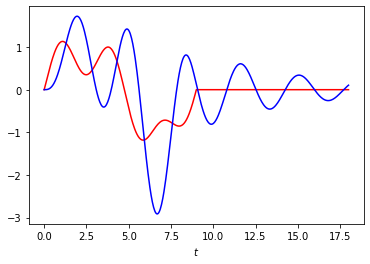

In [10]:
t_sample = np.concatenate((t_sample_T, t_sample_2T))
a_sample = np.concatenate((a_sample_T, a_sample_2T))
u_sample = np.concatenate((u_sample_T, u_sample_2T))

plt.figure(1)
plt.plot(t_sample, a_sample, 'r', t_sample, u_sample, 'b');
plt.xlabel("$t$");

## Anregungs- und Antwortspektrum berechnen

Anregungsspektrum ist gegeben, wird zur Kontrolle nochmal berechnet

In [11]:
dt = t_sample[1] - t_sample[0] 
Na = len(t_sample_T)  
a_f = fft(a_sample_T)    
ta_f = fftfreq(Na, dt) 

Ausgangsspektrum 

In [12]:
Nu = len(t_sample_T) # 
w = hann(Nu)   # Hanning window
uw_f = fft(w*u_sample_T)     
tu_f = fftfreq(Nu, dt)[:Nu//2]

Grafische Darstellung

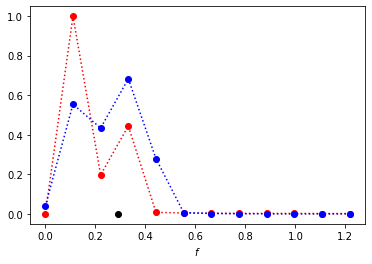

In [13]:
f0=omega_0/(2*np.pi)   # TODO damped eigenfrequency would be better, but needs definition by cases 
plt.figure(2)
plt.plot(ta_f[:Na//20], (2/Na)*np.abs(a_f[:Na//20]), 'ro:', tu_f[:Nu//20], (2/Nu)*np.abs(uw_f[:Nu//20]), 'bo:', f0,0,'ko')
plt.xlabel("$f$");

Warum befinden sich die Maxima beider Spektren bei unterschiedlichen Frequenzen?
Hinweis: Der einzelne schwarze Punkt markiert die (ungedämpfte) 
Eigenfrequenz.

**Zusatzfrage:** die ungedämpfte Eigenfrequenz wäre als Bezug besser geeignet, worauf ist dabei zu achten?